# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Перед нами стоит задача по исследованию рентабельности разработки нефти в трех регионах. Для проведения исследования предоставленны данные о пробах нефти в 100 000 месторождений в каждом регионе. Перед проведением исследования стоит проверить данные на пропуски, дубликаты и выбросы. На основе этих данных необходимо обучить модель, которая будет предсказывать возможный объем сырья в месторождении по трем измеряемым параметрам. После обучения модели необходимо провести анализ рентабельности разработки. Опираясь на предсказания модели выбрать 200 месторождений и подсчитать прибыль, которую можно получить, по известным объемам из предоставленных данных. с помощью техники Bootstrap проведем исследование 1000 выборок по 500 случайных значений симулируя возможную разведку региона, по этим данным высчитаем среднюю прибыль с каждого региона, доверительный интервал в который с точностью 95% попадет возможный результат и риск получить убытки при неудачной разведке региона.

## Загрузка и подготовка данных

Подключим библиотеки, необходимые для исследования.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats as st

Создадим константы, заданные условиями исследования. Бюджет на разработку месторождений. Колличество разрабатываемых месторождений. Цена за 1 тыс. баррелей. Общее колличество исследуемых точек при разработке. Доверительный интервал.

In [2]:
BUDGET = 10_000_000_000
WELLS = 200
BARREL_COST = 450_000
POINTS = 500
CONF_INTERVAL = 0.95

Откроем файлы с данными, предоставленными для исследования.

In [3]:
def read_file(a):
    try:
        data = pd.read_csv(a)
        print('Файл из директории', a, 'загружен')
        return data
    except:
        print('При загрузке файла', a, 'произошел сбой')
        return []

geo_data_0 = read_file('/datasets/geo_data_0.csv')
geo_data_1 = read_file('/datasets/geo_data_1.csv')
geo_data_2 = read_file('/datasets/geo_data_2.csv')

Файл из директории /datasets/geo_data_0.csv загружен
Файл из директории /datasets/geo_data_1.csv загружен
Файл из директории /datasets/geo_data_2.csv загружен


Выведем первые 5 строк каждого полученного датафрейма

In [4]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Все 3 датафрейма состоят из стобца с уникальным id месторождения, с тремя параметрами месторождения: f0, f1, f2 и с запасами сырья в месторождении product представленными в тысячу баррелей на еденицу измерения. 

Посмотрим расспределение значений в каждом датафрейме

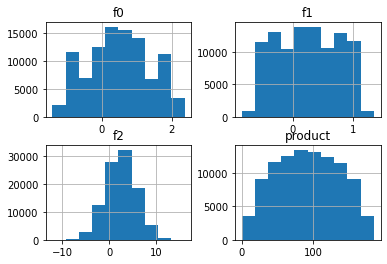

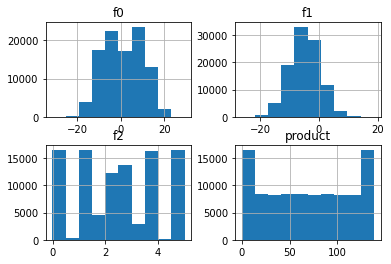

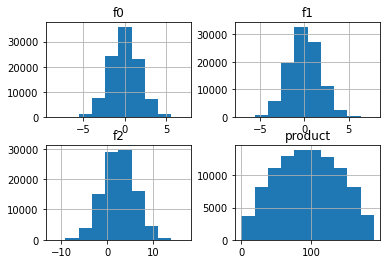

In [5]:
geo_data_0.hist();
geo_data_1.hist();
geo_data_2.hist();

В первом и третьем регионах видим нормальное распределение значений как по параметрам месторождания, так и по объемам. Во втором регионе наблюдаем нормальное распределение по двум признакам и равномерное распределение по третьему, причем итоговые объемы месторождения имеют 3 значения, либо месторождение со скудными запасами, лобо со средними, либо богатое сырьем. Так как предоставленные данные синтетические, нет возможности проверить достоверность предоставленных данных.

Выведем суммарную информацию по трем датафреймам.

In [6]:
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропуски в данных отсутствуют, признаки и целевой столюец представлены числовыми значениями и не требуют изменения формата. Все 3 датафрейма имеют одинаковый размер.

Проверим датафреймы на полные дубликаты.

In [7]:
print('Найдено полных дубликатов:', geo_data_0.duplicated().sum())
print('Найдено полных дубликатов:', geo_data_1.duplicated().sum())
print('Найдено полных дубликатов:', geo_data_2.duplicated().sum())

Найдено полных дубликатов: 0
Найдено полных дубликатов: 0
Найдено полных дубликатов: 0


Проверим на не уникальные значения каждый датафрейм.

In [8]:
display(geo_data_0.nunique())
display(geo_data_1.nunique())
display(geo_data_2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

В каждом датафрейме имеется до 10 неуникальных id месторождения, это возможно связанно с тем, что некоторые месторождения проверяли повторно, причем показания параметров отличаются в каждой записи. В первом и третьем у каждой записи уникальное значение объема в столбце product, во втором столбца всего 12 уникальных значений на 100000 записей.

Разделим данные на признаки features и целевой столбец target. Запишем данные в отдельные переменные для каждого региона.

In [9]:
features_geo0 = geo_data_0.drop(['id', 'product'], axis=1)
target_geo0 = geo_data_0['product']
features_geo1 = geo_data_1.drop(['id', 'product'], axis=1)
target_geo1 = geo_data_1['product']
features_geo2 = geo_data_2.drop(['id', 'product'], axis=1)
target_geo2 = geo_data_2['product']


Разделим общую выбоку на обучающую и валидационную в соотношении 75:25. Запишем данные в отдельные переменные для каждого региона.

In [10]:
features_geo0_train, features_geo0_valid, target_geo0_train, target_geo0_valid = train_test_split(
    features_geo0, target_geo0, test_size=0.25, random_state=12345)
features_geo1_train, features_geo1_valid, target_geo1_train, target_geo1_valid = train_test_split(
    features_geo1, target_geo1, test_size=0.25, random_state=12345)
features_geo2_train, features_geo2_valid, target_geo2_train, target_geo2_valid = train_test_split(
    features_geo2, target_geo2, test_size=0.25, random_state=12345)

После разбиения выборки можно провести маштабирование численных значений методом StandardScaler, но в данном случае метод показал не эффективность и по этому принято решение не использовать его в исследовании.

## Обучение и проверка модели

Обучим модель для каждого региона в отдельности по обучающей выборке.

In [11]:
def model_train(features, target, features_valid):
    model = LinearRegression()
    model.fit(features, target)
    predicted = model.predict(features_valid)
    return model, predicted

model_geo0, predicted_geo0_valid = model_train(features_geo0_train, target_geo0_train, features_geo0_valid)

model_geo1, predicted_geo1_valid = model_train(features_geo1_train, target_geo1_train, features_geo1_valid)

model_geo2, predicted_geo2_valid = model_train(features_geo2_train, target_geo2_train, features_geo2_valid)


Подсчитаем средние предсказанные запасы и RSME для каждого региона. RMSE - это метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше модель соответствует набору данных.

In [18]:
def print_mean_rmse(predicted,target_valid, counter):
    print('Средние запасы предсказанного сырья по', counter, 'региону', predicted.mean())
    print('RMSE для модели', counter, 'региона', (mean_squared_error(target_valid, predicted)) ** 0.5, '\n')
    counter+=1
    return counter

counter = 1
counter = print_mean_rmse(predicted_geo0_valid, target_geo0_valid, counter)

counter = print_mean_rmse(predicted_geo1_valid, target_geo1_valid, counter)

counter = print_mean_rmse(predicted_geo2_valid, target_geo2_valid, counter)


Средние запасы предсказанного сырья по 1 региону 92.59256778438035
RMSE для модели 1 региона 37.5794217150813 

Средние запасы предсказанного сырья по 2 региону 68.728546895446
RMSE для модели 2 региона 0.893099286775617 

Средние запасы предсказанного сырья по 3 региону 94.96504596800489
RMSE для модели 3 региона 40.02970873393434 



Из полученных данных первый и третий регион практически идеетичны по средним предсказанным запасам, разница в 2.4 тыс. баррелей на месторождение. RMSE для третьего региона самый высокий и составляет 40 тыс. баррелей на месторождение, для первого региона RMSE так же отличается на 2.4 тыс. баррелей и составляет приблизительно 37.6 тыс. баррелей на месторождение.

Второй регион при этом является самым скудным по средним запасам предсказанного сырья - 68.7, а RMSE для второго региона составляет 0.9 тыс. баррелей на месторождение.

Соответственно с учетом RMSE для первого и третьего региона запас сырья на месторождение может колебаться в диапазоне 55-130 тыс. баррелей если будет предсказанно среднее значение запасов для месторождения. А во втором регионе колебание 67.8-69.6 тыс. баррелей на месторождение.

## Подготовка к расчёту прибыли

Подсчитаем минимальное колличество тыс. баррелей в разрабатываемой скважине для безубыточной добычи.

In [19]:
min_barrels = (BUDGET/WELLS)/BARREL_COST
print('Минимальное колличество тыс. баррелей в разрабатываемой скважине для безубыточной добычи', round(min_barrels, 2))

Минимальное колличество тыс. баррелей в разрабатываемой скважине для безубыточной добычи 111.11


Подсчитаем средние запасы сырья в каждом регионе.

In [20]:
print('Средние запасы сырья в 1 регионе:', target_geo0.mean())
print('Средние запасы сырья в 2 регионе:', target_geo1.mean())
print('Средние запасы сырья в 3 регионе:', target_geo2.mean())

Средние запасы сырья в 1 регионе: 92.50000000000001
Средние запасы сырья в 2 регионе: 68.82500000000002
Средние запасы сырья в 3 регионе: 95.00000000000004


По средним зарасам сырья перспективнее выглядят первый и третий регионы, разница между ними всего в 2.5 тыс баррелей. Второй регион по средним запасам самый скудный. 

Если сравнить с минимальным колличеством запасов сырья для безубыточной разработки, первый и третий регион, приблизительно на 15% отстают от этого показателя, и если разрабатывать все подряд месторождения, то шанс получить убытки очень высок. Во втором регионе это отношение составляет почти половину от минимального колличества.

Напишем функцию, которая будет высчитывать возможную реальную прибыль для заданного колличества лучших из предсказанных месторождений, с учетом бюджета на разработку. Функция получает на вход предсказанные объемы, реальные объемы из предоставленных данных,бюджет на разработку, колличество разрабатываемых месторождений, цена за тыс. баррелей. Ны выходе получаем итоговую прибыль.

In [21]:
def profit(predicted, target, BUDGET, WELLS, BARREL_COST):
    probs_sorted = predicted.sort_values(ascending=False)
    selected = target[probs_sorted.index][:WELLS]
    return int(selected.sum())*BARREL_COST - BUDGET
       

Проверим работоспособость функции

In [22]:
print('Пердсказанная прибыль для первого региона', profit(pd.Series(predicted_geo0_valid), target_geo0_valid.reset_index(drop=True), BUDGET, WELLS, BARREL_COST))
print('Пердсказанная прибыль для второго региона', profit(pd.Series(predicted_geo1_valid), target_geo1_valid.reset_index(drop=True), BUDGET, WELLS, BARREL_COST))
print('Пердсказанная прибыль для третьего региона', profit(pd.Series(predicted_geo2_valid), target_geo2_valid.reset_index(drop=True), BUDGET, WELLS, BARREL_COST))


Пердсказанная прибыль для первого региона 3320450000
Пердсказанная прибыль для второго региона 2415050000
Пердсказанная прибыль для третьего региона 2710250000


Полученные цыфры, максимально возможная прибыль, если будут разрабатываться только лучшие месторождения в регионе.

## Расчёт прибыли и рисков 

С помощью метода Bootstrap проведем 1000 выборок для определения средней прибыли с региона, доверительного интервала и риск убытков.

In [30]:
def total_research(predicted, target, BUDGET, WELLS, BARREL_COST, POINTS, CONF_INTERVAL):
    state = np.random.RandomState(12345)

    target = target.reset_index(drop=True)
    predicted = pd.Series(predicted)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=POINTS, replace=True, random_state=state)
        probs_subsample = predicted[target_subsample.index] 
        values.append(profit(probs_subsample, target_subsample, BUDGET, WELLS, BARREL_COST))

    values = pd.Series(values)

    print("Cредняя прибыль для региона:", values.mean())
    

    confidence_interval = st.t.interval(CONF_INTERVAL, len(values)-1, values.mean(), values.sem())

    print("95%-ый доверительный интервал:", values.quantile(0.025), '....', values.quantile(0.975))
    print()
    print('Риск убытков', ((values<0).mean()*100), '%')
    return

Проведем вычисления для первого региона

In [31]:
total_research(predicted_geo0_valid, target_geo0_valid, BUDGET, WELLS, BARREL_COST, POINTS, CONF_INTERVAL)

Cредняя прибыль для региона: 425717450.0
95%-ый доверительный интервал: -102306250.0 .... 947656250.0

Риск убытков 6.0 %


Проведем вычисления для второго региона

In [32]:
total_research(predicted_geo1_valid, target_geo1_valid, BUDGET, WELLS, BARREL_COST, POINTS, CONF_INTERVAL)

Cредняя прибыль для региона: 514989350.0
95%-ый доверительный интервал: 68716250.0 .... 931445000.0

Риск убытков 1.0 %


Проведем вычисления для третьего региона

In [33]:
total_research(predicted_geo2_valid, target_geo2_valid, BUDGET, WELLS, BARREL_COST, POINTS, CONF_INTERVAL)

Cредняя прибыль для региона: 434773250.0
95%-ый доверительный интервал: -129317500.0 .... 969672500.0

Риск убытков 6.4 %


## Вывод

В текущем исследовании были обучены модели для трех регионов, которые предсказывают объем сырья, по параметрам замеров нефти в месторождении. С помощью обученных моделей были исследованы 3 региона, на результатах предсказаний котрых, была проведена симуляция выбора 500 случайных месторождений из которых выбиралось 200 лучших, на основе предскзанных запасов, и для этих месторождений высчитывалась итоговая возможная прибыль, на основе запасов по месторождениям из предоставленных реальных данных, данная процедура прошла 1000 повторений. По результатам симуляции получены следующие данные: средняя прибыль с региона, доверительный интервал и риск убытков. Доверительный интервал показывает, среди каких значений с заданным шансом скорее всего будет итоговая средняя прибыль с региона при реальной разработке региона.

По условиям исследования, риск разработки в регионе не должен превышать 2.5%, соответственно нам подходит только второй регион, причем средняя прибыть по результатам работы алгоритма самая высокая среди трех регионов и составляет 514 989 350 рублей. 

Модель обучения для второго региона показывала самый низкий показатель средней квадратичной разницы между прогнозируемыми значениями и фактическими и соответственно данная модель наиболее точно предсказывала объем сырья в месторождении.